## Notebook for Molecular Diffusion
based on "Equivariant Diffusion for Molecule Generation in 3D" by Emiel Hoogeboom, Victor Garcia Satorras, Clement Vignac and Max Welling,  https://arxiv.org/pdf/2203.17003.pdf

The notebook is a guide to various parts of the source code.  To follow this you should download the source
from github https://github.com/ehoogeboom/e3_diffusion_for_molecules. 99% of the code here comes from the repository.  it has only been modified so that it will work in the notebook.   run the notebook from the main directory.

There are four parts to this notebook.

1. loading the dataset and visualizing molecules from qm9

2. Testing a molecule for stablity

3. Demonstration of the Equivariance of the Model

4. Denoising a random sample based on the trianed model  and visualizing the chain and creating a movie.



In [1]:
from qm9 import dataset

In [2]:

from tkinter import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob


In [3]:
#import utils  #this is from the github download.
import argparse
#from configs.datasets_config import qm9_with_h, qm9_without_h
from qm9.models import get_model

import torch
import pickle
from os.path import join
from configs.datasets_config import get_dataset_info
import imageio
matplotlib.use('TkAgg')

import os

In [4]:
#from tkinter import *
import qm9.visualizer as vis
from torch.nn import functional as F

In [5]:
dataset_info = get_dataset_info('qm9', False)

In [6]:
dataset_info

{'name': 'qm9',
 'atom_encoder': {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4},
 'atom_decoder': ['H', 'C', 'N', 'O', 'F'],
 'n_nodes': {22: 3393,
  17: 13025,
  23: 4848,
  21: 9970,
  19: 13832,
  20: 9482,
  16: 10644,
  13: 3060,
  15: 7796,
  25: 1506,
  18: 13364,
  12: 1689,
  11: 807,
  24: 539,
  14: 5136,
  26: 48,
  7: 16,
  10: 362,
  8: 49,
  9: 124,
  27: 266,
  4: 4,
  29: 25,
  6: 9,
  5: 5,
  3: 1},
 'max_n_nodes': 29,
 'atom_types': {1: 635559, 2: 101476, 0: 923537, 3: 140202, 4: 2323},
 'distances': [903054,
  307308,
  111994,
  57474,
  40384,
  29170,
  47152,
  414344,
  2202212,
  573726,
  1490786,
  2970978,
  756818,
  969276,
  489242,
  1265402,
  4587994,
  3187130,
  2454868,
  2647422,
  2098884,
  2001974,
  1625206,
  1754172,
  1620830,
  1710042,
  2133746,
  1852492,
  1415318,
  1421064,
  1223156,
  1322256,
  1380656,
  1239244,
  1084358,
  981076,
  896904,
  762008,
  659298,
  604676,
  523580,
  437464,
  413974,
  352372,
  291886,
  271948,
  2

In [7]:
#you can use cuda if you have it install
device = torch.device("cuda")
device = torch.device('cpu')
dtype = torch.float32

#### Args
in the code in the github archive there are a large number of parameters.  To simplify the notebook we load them all here as a python object of class "args".

In [8]:
class args:
    actnorm=True 
    aggregation_method='sum' 
    attention=True 
    augment_noise=0 
    batch_size=1
    break_train_epoch=False 
    brute_force=False 
    clip_grad=True 
    condition_time=True 
    conditioning=[] 
    context_node_nf=0 
    cuda=False 
    current_epoch=1001 
    data_augmentation=False 
    datadir='qm9/temp' 
    dataset='qm9' 
    dequantization='argmax_variational' 
    device='cpu' 
    diffusion_loss_type='l2' 
    diffusion_noise_precision=1e-05 
    diffusion_noise_schedule='polynomial_2' 
    diffusion_steps=1000 
    dp=True 
    ema_decay=0.9999 
    exp_name='polynomial_2_final_0' 
    filter_n_atoms=None 
    generate_epochs=1 
    include_charges=True 
    inv_sublayers=1 
    lr=0.0001 
    model='egnn_dynamics' 
    n_epochs=3000 
    n_layers=9 
    n_report_steps=1 
    n_stability_samples=1000 
    nf=256 
    no_cuda=False 
    no_wandb=False 
    norm_constant=1 
    normalization_factor=1 
    normalize_factors=[1,4, 10] 
    num_workers=0 
    ode_regularization=0.001 
    online=True 
    probabilistic_model='diffusion' 
    remove_h=False 
    resume=None 
    save_model=True 
    sin_embedding=False 
    start_epoch=0 
    tanh=True 
    test_epochs=20 
    trace='hutch' 
    visualize_every_batch=100000000.0 
    wandb_usr=None  
    model_path='outputs/edm_qm9'
    
args = args()

In [9]:
dataset_info['atom_encoder']

{'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}

In [10]:
dataset_info['atom_decoder']

['H', 'C', 'N', 'O', 'F']

In [11]:
# Retrieve QM9 dataloaders
dataloaders, charge_scale = dataset.retrieve_dataloaders(args)

### Molecule visualization tools
The graph of a molecule here is complete (every node connected to every other node) and configureations are purely based on geometric position and distances. However, atoms in molecules are linked by bonds.   the decision on the type of bonds that exist in the molecules here is based distance and the dictionaries below.

In [12]:
bonds1 = {'H': {'H': 74, 'C': 109, 'N': 101, 'O': 96, 'F': 92,
                'B': 119, 'Si': 148, 'P': 144, 'As': 152, 'S': 134,
                'Cl': 127, 'Br': 141, 'I': 161},
          'C': {'H': 109, 'C': 154, 'N': 147, 'O': 143, 'F': 135,
                'Si': 185, 'P': 184, 'S': 182, 'Cl': 177, 'Br': 194,
                'I': 214},
          'N': {'H': 101, 'C': 147, 'N': 145, 'O': 140, 'F': 136,
                'Cl': 175, 'Br': 214, 'S': 168, 'I': 222, 'P': 177},
          'O': {'H': 96, 'C': 143, 'N': 140, 'O': 148, 'F': 142,
                'Br': 172, 'S': 151, 'P': 163, 'Si': 163, 'Cl': 164,
                'I': 194},
          'F': {'H': 92, 'C': 135, 'N': 136, 'O': 142, 'F': 142,
                'S': 158, 'Si': 160, 'Cl': 166, 'Br': 178, 'P': 156,
                'I': 187},
          'B': {'H':  119, 'Cl': 175},
          'Si': {'Si': 233, 'H': 148, 'C': 185, 'O': 163, 'S': 200,
                 'F': 160, 'Cl': 202, 'Br': 215, 'I': 243 },
          'Cl': {'Cl': 199, 'H': 127, 'C': 177, 'N': 175, 'O': 164,
                 'P': 203, 'S': 207, 'B': 175, 'Si': 202, 'F': 166,
                 'Br': 214},
          'S': {'H': 134, 'C': 182, 'N': 168, 'O': 151, 'S': 204,
                'F': 158, 'Cl': 207, 'Br': 225, 'Si': 200, 'P': 210,
                'I': 234},
          'Br': {'Br': 228, 'H': 141, 'C': 194, 'O': 172, 'N': 214,
                 'Si': 215, 'S': 225, 'F': 178, 'Cl': 214, 'P': 222},
          'P': {'P': 221, 'H': 144, 'C': 184, 'O': 163, 'Cl': 203,
                'S': 210, 'F': 156, 'N': 177, 'Br': 222},
          'I': {'H': 161, 'C': 214, 'Si': 243, 'N': 222, 'O': 194,
                'S': 234, 'F': 187, 'I': 266},
          'As': {'H': 152}
          }
bonds2 = {'C': {'C': 134, 'N': 129, 'O': 120, 'S': 160},
          'N': {'C': 129, 'N': 125, 'O': 121},
          'O': {'C': 120, 'N': 121, 'O': 121, 'P': 150},
          'P': {'O': 150, 'S': 186},
          'S': {'P': 186}}


bonds3 = {'C': {'C': 120, 'N': 116, 'O': 113},
          'N': {'C': 116, 'N': 110},
          'O': {'C': 113}}
margin1 = 10
margin2 = 5
margin3 = 3

allowed_bonds = {'H': 1, 'C': 4, 'N': 3, 'O': 2, 'F': 1, 'B': 3, 'Al': 3,
                 'Si': 4, 'P': [3, 5],
                 'S': 4, 'Cl': 1, 'As': 3, 'Br': 1, 'I': 1, 'Hg': [1, 2],
                 'Bi': [3, 5]}

In [13]:
#this computes the bonds between two atom in the graph.

def get_bond_order(atom1, atom2, distance, check_exists=False):
    distance = 100 * distance  # We change the metric

    # Check exists for large molecules where some atom pairs do not have a
    # typical bond length.
    if check_exists:
        if atom1 not in bonds1:
            return 0
        if atom2 not in bonds1[atom1]:
            return 0

    # margin1, margin2 and margin3 have been tuned to maximize the stability of
    # the QM9 true samples.
    if distance < bonds1[atom1][atom2] + margin1:

        # Check if atoms in bonds2 dictionary.
        if atom1 in bonds2 and atom2 in bonds2[atom1]:
            thr_bond2 = bonds2[atom1][atom2] + margin2
            if distance < thr_bond2:
                if atom1 in bonds3 and atom2 in bonds3[atom1]:
                    thr_bond3 = bonds3[atom1][atom2] + margin3
                    if distance < thr_bond3:
                        return 3        # Triple
                return 2            # Double
        return 1                # Single
    return 0                    # No bond


In [14]:
def geom_predictor(p, l, margin1=5, limit_bonds_to_one=False):
    """ p: atom pair (couple of str)
        l: bond length (float)"""
    bond_order = get_bond_order(p[0], p[1], l, check_exists=True)

    # If limit_bonds_to_one is enabled, every bond type will return 1.
    if limit_bonds_to_one:
        return 1 if bond_order > 0 else 0
    else:
        return bond_order


In [15]:
#the functions below render the molecule and draw the bonds when they are deemed to exist. 
matplotlib.use('TkAgg')

def plot_molecule(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color,
                  dataset_info):
    # draw_sphere(ax, 0, 0, 0, 1)
    # draw_sphere(ax, 1, 1, 1, 1)

    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    # ax.set_facecolor((1.0, 0.47, 0.42))
    colors_dic = np.array(dataset_info['colors_dic'])
    radius_dic = np.array(dataset_info['radius_dic'])
    area_dic = 1500 * radius_dic ** 2
    # areas_dic = sizes_dic * sizes_dic * 3.1416

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if spheres_3d:
        for i, j, k, s, c in zip(x, y, z, radii, colors):
            vis.draw_sphere(ax, i.item(), j.item(), k.item(), 0.7 * s, c, alpha)
    else:
        ax.scatter(x, y, z, s=areas, alpha=0.9 * alpha,
                   c=colors)  # , linewidths=2, edgecolors='#FFFFFF')
    #print('time for edges')
    for i in range(len(atom_type)):
        for j in range(i+1, len(atom_type)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = dataset_info['atom_decoder'][atom_type[i]], dataset_info['atom_decoder'][atom_type[j]]
            s = sorted((atom_type[i], atom_type[j]))
            pair = (dataset_info['atom_decoder'][s[0]],
                    dataset_info['atom_decoder'][s[1]])
            if 'qm9' in dataset_info['name']:
                draw_edge_int = get_bond_order(atom1, atom2, dist)
                #print("atom pair", str(pair)+ " bond_order "+ str(draw_edge_int))
                line_width = (3 - 2) * 2 * 2
            elif dataset_info['name'] == 'geom':
                draw_edge_int = geom_predictor(pair, dist)
                # Draw edge outputs 1 / -1 value, convert to True / False.
                line_width = 2
            else:
                raise Exception('Wrong dataset_info name')
            #print("draw_edge_int", draw_edge_int)
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    # linewidth_factor = draw_edge_int  # Prop to number of
                    # edges.
                    linewidth_factor = 1
                ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                        linewidth=line_width * linewidth_factor,
                        c=hex_bg_color, alpha=alpha)


def plot_data3d(positions, atom_type, dataset_info, camera_elev=0, camera_azim=0, save_path=None, spheres_3d=False,
                bg='black', alpha=1.):
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#666666'

    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    # ax.xaxis.pane.set_edgecolor('#D0D0D0')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")
    print(positions.shape, atom_type)
    plot_molecule(ax, positions, atom_type, alpha, spheres_3d,
                  hex_bg_color, dataset_info)

    if 'qm9' in dataset_info['name']:
        max_value = positions.abs().max().item()

        # axis_lim = 3.2
        axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)
    elif dataset_info['name'] == 'geom':
        max_value = positions.abs().max().item()

        # axis_lim = 3.2
        axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)
    else:
        raise ValueError(dataset_info['name'])

    dpi = 120 if spheres_3d else 50

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
    else:
        plt.show()
    plt.close()

we render molecules in two different ways.  in the case where we have a lot of them to render we use the functions above.  but we can render indivual ones directly from the notebook (in a seperate window) using the functions below.

In [16]:
def load_molecule_xyz_nb(data_dummy, dataset_info):
    n_atoms = int(data_dummy['num_atoms'].numpy()[0])
    one_hot = torch.zeros(n_atoms, len(dataset_info['atom_decoder']))
    #charges = torch.zeros(n_atoms, 1)
    charges = data_dummy['charges'][0]
    positions =data_dummy['positions'][0]
    for i in range(n_atoms):
        one_hot[i, (data_dummy['one_hot'][0][i]==True).nonzero().item()] = 1
    return positions, one_hot, charges

In [17]:
def visualize_nb(data_dummy, dataset_info, max_num=25, wandb=None, spheres_3d=True):
    positions, one_hot, charges = load_molecule_xyz_nb(data_dummy, dataset_info)
    atom_type = torch.argmax(one_hot, dim=1).numpy()
    dists = torch.cdist(positions.unsqueeze(0), positions.unsqueeze(0)).squeeze(0)
    dists = dists[dists > 0]
    print("Average distance between atoms", dists.mean().item())
    print(positions.shape, atom_type)
    #atoml = list(atom_type)
    #atoml.append(1)
    #atom_type = np.array(atoml)
    print(atom_type)
    plot_data3d(positions, atom_type, dataset_info=dataset_info,
                spheres_3d=spheres_3d)





In [18]:
#This is an example of rendering from the notebook.

data_dummy = next(iter(dataloaders['train']))


In [19]:
#this should cause a new window to come up  with the molecule.  you can rotate the image to see its structure better..

visualize_nb(data_dummy, dataset_info)

Average distance between atoms 2.849806785583496
torch.Size([16, 3]) [1 3 1 1 1 3 1 2 1 0 0 0 0 0 0 0]
[1 3 1 1 1 3 1 2 1 0 0 0 0 0 0 0]
torch.Size([16, 3]) [1 3 1 1 1 3 1 2 1 0 0 0 0 0 0 0]


C:\Users\denni\AppData\Local\Temp\ipykernel_14208\4116508464.py:86: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("black")


### examine stability of the data_dummy sample


In [20]:
def check_stability(positions, atom_type, dataset_info, debug=False):
    assert len(positions.shape) == 2
    assert positions.shape[1] == 3
    atom_decoder = dataset_info['atom_decoder']
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]

    nr_bonds = np.zeros(len(x), dtype='int')

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = atom_decoder[atom_type[i]], atom_decoder[atom_type[j]]
            pair = sorted([atom_type[i], atom_type[j]])
            if dataset_info['name'] == 'qm9' or dataset_info['name'] == 'qm9_second_half' or dataset_info['name'] == 'qm9_first_half':
                order = get_bond_order(atom1, atom2, dist)
            elif dataset_info['name'] == 'geom':
                order = geom_predictor(
                    (atom_decoder[pair[0]], atom_decoder[pair[1]]), dist)
            nr_bonds[i] += order
            nr_bonds[j] += order
    nr_stable_bonds = 0
    for atom_type_i, nr_bonds_i in zip(atom_type, nr_bonds):
        possible_bonds = allowed_bonds[atom_decoder[atom_type_i]]
        if type(possible_bonds) == int:
            is_stable = possible_bonds == nr_bonds_i
        else:
            is_stable = nr_bonds_i in possible_bonds
        if not is_stable and debug:
            print("Invalid bonds for molecule %s with %d bonds" % (atom_decoder[atom_type_i], nr_bonds_i))
        nr_stable_bonds += int(is_stable)

    molecule_stable = nr_stable_bonds == len(x)
    return molecule_stable, nr_stable_bonds, len(x)

In [21]:
i = 0
x = data_dummy['positions'].to(device, dtype)
node_mask = data_dummy['atom_mask'].to(device,dtype).unsqueeze(2)
edge_mask = data_dummy['edge_mask'].to(device, dtype)
one_hot = data_dummy['one_hot'].to(device, dtype)
charges = data_dummy['charges']
h = {'categorical': one_hot, 'integer': charges}
num_atoms = int(node_mask[i:i+1].sum().item())
atom_type = one_hot[i:i+1, :num_atoms].argmax(2).squeeze(0).cpu().detach().numpy()
x_squeeze = x[i:i+1, :num_atoms].squeeze(0).cpu().detach().numpy()
mol_stable , stable_bonds, outof = check_stability(x_squeeze, atom_type, dataset_info)
print('mol stabilty ', mol_stable, ' num stable bonds ', stable_bonds, " out of", outof)

mol stabilty  True  num stable bonds  16  out of 16


Note that each node has a vector h that is composed of a one-hot vector that describes the atom type and an integer representing the charge.

In [22]:
one_hot

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]]])

In [23]:
atom_type

array([1, 3, 1, 1, 1, 3, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [24]:
charges

tensor([[[6],
         [8],
         [6],
         [6],
         [6],
         [8],
         [6],
         [7],
         [6],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]]])

### vertify that the network is equivariant.
To show eqivariant we need to show that if we apply a transformation Q to the tensor of node coordinates and then run that through the network that this is equivalent to applying the transformation to the output of the network.  We keep in mind that the application of the transformation is matrix multiplication and that the node data h is independent of the coordinates.  the network returns two results: and x component and an h component
$$
\phi( x,~h)Q  ~=~ \phi( xQ,~h)  
$$
or, more formally, 
$$
 \phi( x,~h)Q ~ \rightarrow ~ (\phi_x(x, ~h)Q , ~\phi_y(x, ~h) ) ~=~ \phi( xQ,~h) 
$$

In [25]:
#first let's load the trained network.

flow, nodes_dist, prop_dist = get_model(
        args, device, dataset_info, dataloaders['train'])
flow.eval()
fn = 'generative_model_ema.npy' if args.ema_decay > 0 else 'generative_model.npy'
flow_state_dict = torch.load(join(args.model_path, fn),
                                 map_location=device)
flow.load_state_dict(flow_state_dict)
#flow.eval()

Entropy of n_nodes: H[N] -2.475700616836548
alphas2 [9.99990000e-01 9.99988000e-01 9.99982000e-01 ... 2.59676966e-05
 1.39959211e-05 1.00039959e-05]
gamma [-11.51291546 -11.33059532 -10.92513058 ...  10.55863126  11.17673063
  11.51251595]


<All keys matched successfully>

we are going to use the the equivariant core of our network

flow.dynamics.egnn(xh[0], x[0], edges.T)

which requires three parameters, an extended version of h,  the point locations, and the transpose of the edge table.


In [26]:
#we extract an example from the training set so we can build [x, h]
data_dummy = next(iter(dataloaders['train']))

x = data_dummy['positions'].to(device, dtype) 
node_mask = data_dummy['atom_mask'].to(device,dtype).unsqueeze(2)
num_atoms = int(node_mask[0:1].sum().item())
print("num atoms ", num_atoms)
edge_mask = data_dummy['edge_mask'].to(device, dtype)
one_hot = data_dummy['one_hot'].to(device, dtype)
charges = data_dummy['charges']
h = {'categorical': one_hot, 'integer': charges}
#normally we remove the mean of x befor sending it to the network, but for this test it is not necessary
#x = remove_mean_with_mask(x, node_mask)


num atoms  18


#### Edge tables
if we have a specific molecule we can make the table of edges with the function below.  But in the case of a general molecule we treat the graph as being complete.   For that we use the second method below works.   

In [27]:
def make_actual_edges(positions, atom_type, dataset_info ):
    edge_list = []
    x = positions[:, 0].cpu()
    y = positions[:, 1].cpu()
    z = positions[:, 2].cpu()

    for i in range(len(atom_type)):
        for j in range(i+1, len(atom_type)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = dataset_info['atom_decoder'][atom_type[i]], dataset_info['atom_decoder'][atom_type[j]]
            s = sorted((atom_type[i], atom_type[j]))
            pair = (dataset_info['atom_decoder'][s[0]],
                    dataset_info['atom_decoder'][s[1]])
            if 'qm9' in dataset_info['name']:
                draw_edge_int = get_bond_order(atom1, atom2, dist)
                if draw_edge_int > 0:
                    edge_list.append([i,j])
                    edge_list.append([j,i])

                    #print("atom pair", str(pair)+ " bond_order "+ str(draw_edge_int))
    return edge_list


In [28]:
def make_edges(num_atoms):
    edge_list = []
    for i in range(len(atom_type)):
        for j in range(i+1, len(atom_type)):
                edge_list.append([i,j])
                edge_list.append([j,i])
    return edge_list


In [29]:
el = make_edges(num_atoms)
edges = torch.tensor(el).to(device)
edges.shape

torch.Size([240, 2])

we need to extend the h vector by one element for each atom.   that value is related to the time step. For this test it does not matter what it is. 

In [30]:
newcol = torch.zeros([1,num_atoms,1])+0.5  #this is time stamp related.
newcol = newcol.to(device, dtype)

In [31]:
newcol.shape

torch.Size([1, 18, 1])

In [32]:
h['integer'] =h['integer'].to(device, dtype)

In [33]:
edges.T.shape

torch.Size([2, 240])

In [34]:
xh = torch.cat([ h['categorical'] ,h['integer'], newcol], dim=2)
xh.shape

torch.Size([1, 18, 7])

In [35]:
nh, nx = flow.dynamics.egnn(xh[0], x[0], edges.T)

#### create a simple rotation matrix
To do the transformantion Q we will create a simple rotation matrix 

In [36]:
Q = torch.zeros([3,3])
Q[0,0] = np.cos(0.3)
Q[0,1] = -np.sin(0.3)
Q[1,0] = np.sin(0.3)
Q[1,1] = np.cos(0.3)
Q[2,2] = 1.
Q=Q.to(device, dtype)

In [37]:
xq = torch.matmul(x,Q)

In [38]:
nhq, nxq = flow.dynamics.egnn(xh[0], xq[0], edges.T)


now do the commputation to show "equality"

In [39]:
xsq = (nx - torch.matmul(nxq,Q.T))**2
torch.sum(xsq)

tensor(1.6354e-11, grad_fn=<SumBackward0>)

In [40]:
torch.sum((nh-nhq)**2)

tensor(4.4366e-11, grad_fn=<SumBackward0>)

### Test Denoising: sample z and work back to x building a chain 
This illustrates the denoising process by starting with a random noise and denoising it with the trained network from T=1000 to T=0.   The result will be a sequence of images as shown below.    Again, the code is pulled from the author's source.   This is all made easy because the model "flow" has a method called sample chain.  the majority of the code below is creating the visualizations

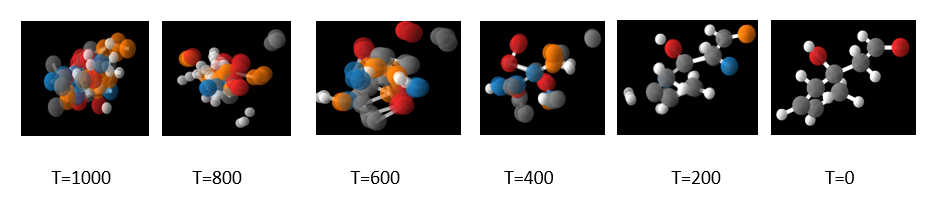

In [41]:
import os
# First a few more graphics functions.  The last function sample_only_stable_different_sizes_and_save
# simply calls sample chain until it create a final image that is stable.  

def load_molecule_xyz(file, dataset_info):
    with open(file, encoding='utf8') as f:
        n_atoms = int(f.readline())
        print("num atoms =", n_atoms)
        one_hot = torch.zeros(n_atoms, len(dataset_info['atom_decoder']))
        charges = torch.zeros(n_atoms, 1)
        positions = torch.zeros(n_atoms, 3)
        f.readline()
        atoms = f.readlines()
        for i in range(n_atoms):
            atom = atoms[i].split(' ')
            atom_type = atom[0]
            one_hot[i, dataset_info['atom_encoder'][atom_type]] = 1
            position = torch.Tensor([float(e) for e in atom[1:]])
            positions[i, :] = position
        return positions, one_hot, charges

def load_xyz_files(path, shuffle=False):
    files = glob.glob(path + "/*.txt")
    if shuffle:
        random.shuffle(files)
    return files

def visualize(path, dataset_info, max_num=25, wandb=None, spheres_3d=False):
    files = load_xyz_files(path)[0:max_num]
    for file in files:
        print("file=", file)
        positions, one_hot, charges = load_molecule_xyz(file, dataset_info)
        atom_type = torch.argmax(one_hot, dim=1).numpy()
        dists = torch.cdist(positions.unsqueeze(0), positions.unsqueeze(0)).squeeze(0)
        dists = dists[dists > 0]
        print("Average distance between atoms", dists.mean().item())
        plot_data3d(positions, atom_type, dataset_info=dataset_info, save_path=file[:-4] + '.png',
                    spheres_3d=spheres_3d)

        if wandb is not None:
            path = file[:-4] + '.png'
            # Log image(s)
            im = plt.imread(path)
            wandb.log({'molecule': [wandb.Image(im, caption=path)]})


def save_xyz_file(path, one_hot, charges, positions, dataset_info, id_from=0, name='molecule', node_mask=None):
    try:
        os.makedirs(path)
    except OSError:
        pass

    if node_mask is not None:
        atomsxmol = torch.sum(node_mask, dim=1)
    else:
        atomsxmol = [one_hot.size(1)] * one_hot.size(0)
    #print('atomxmol=', atomsxmol,  one_hot.size(0))
    #print('one_hot=', one_hot)
    
    for batch_i in range(1):
        #print('batch_i ', batch_i)
        f = open(path + name + '_' + "%03d.txt" % (batch_i + id_from), "w")
        #f.write("%d\n\n" % atomsxmol[0])
        #print(one_hot[batch_i])
        atoms = torch.argmax(one_hot[0], dim=1)
        #print("atoms=" , atoms)
        n_atoms = one_hot.size(1)
        print("n_atoms=", n_atoms)
        f.write("%d\n\n" % n_atoms)
        for atom_i in range(n_atoms):
            atom = atoms[atom_i]
            atom = dataset_info['atom_decoder'][atom]
            #print('atom_i=', atom_i, 'atom=',atom)
            f.write("%s %.9f %.9f %.9f\n" % (atom, positions[batch_i, atom_i, 0], positions[batch_i, atom_i, 1], positions[batch_i, atom_i, 2]))
        f.close()



def save_chain(chain, number, path):
    first = True
    stable = False
    for k in range(number):
        z = chain
        x = z[k:k+1, :, 0:3]
        print('x.shape ', x.shape)
        charges = z[k:k+1, :, -1]
        print("charges.shapes",charges.shape)
        one_hot = z[k:k+1, :, 3:-1]
        atom_type = torch.argmax(one_hot, dim=2)
        print('one_hot.shape', one_hot.shape)
        atom_type = atom_type.squeeze(0).cpu().detach().numpy()
        print('atom_type' ,atom_type)
        x_squeeze = x.squeeze(0)
        print('x squeez.shape', x_squeeze.shape)
        print("saving no ", k, one_hot.shape)
        save_xyz_file(
                    join(args.model_path, 'eval/'+path+'/'),
                    one_hot, charges[0], x,
                    id_from=k, name='molecule_stable',
                    dataset_info=dataset_info,
                    node_mask=node_mask)
            
        
    return stable

def sample_only_stable_different_sizes_and_save(
        args, device, flow, file, 
        dataset_info, n_images=10, n_tries=50):
    #flow = flow.cpu()
    counter = 0
    for i in range(n_tries):
        n_samples = 1
        n_nodes = 20
        context = None
        node_mask = torch.ones(n_samples, n_nodes, 1).to(device)
        edge_mask = (1 - torch.eye(n_nodes)).unsqueeze(0).to(device)
        edge_mask = edge_mask.repeat(n_samples, 1, 1).view(-1, 1).to(device)
        counter = 0
        found = False
        chain = flow.sample_chain(n_samples, n_nodes, node_mask, edge_mask, context, keep_frames=n_images)
        z = chain
        x = z[0:1, :, 0:3]
        one_hot = z[0:1, :, 3:-1]
        atom_type = torch.argmax(one_hot, dim=2)
        atom_type = atom_type.squeeze(0).to(device).detach().numpy()
        x_squeeze = x.squeeze(0)
        mol_stable, a, b = check_stability(x_squeeze, atom_type, dataset_info)
        if mol_stable:
            save_chain(chain, n_images, file)
            visualize(
                join(args.model_path, 'eval/'+file+'/'), dataset_info,
                max_num=n_images, spheres_3d=True)
            break
        counter =+1
        print("counter =", counter)    
    return(chain)


In [42]:
chain = sample_only_stable_different_sizes_and_save(args, device, flow, 'mols10', dataset_info, n_images = 10)

counter = 1
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
x squeez.shape torch.Size([20, 3])
saving no  0 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
x squeez.shape torch.Size([20, 3])
saving no  1 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
x squeez.shape torch.Size([20, 3])
saving no  2 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
x squeez.shape torch.Size([20, 3])
saving no  3 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])


n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [0 0 1 1 3 0 1 1 4 3 2 1 0 2 3 0 4 4 1 0]
x squeez.shape torch.Size([20, 3])
saving no  54 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [0 0 0 1 3 0 1 1 4 3 2 1 0 2 3 0 4 4 1 0]
x squeez.shape torch.Size([20, 3])
saving no  55 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [1 0 0 1 2 0 1 1 4 3 2 2 0 2 3 0 4 4 1 0]
x squeez.shape torch.Size([20, 3])
saving no  56 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [1 0 0 2 3 0 1 1 4 1 2 2 0 2 3 0 4 4 1 0]
x squeez.shape torch.Size([20, 3])
saving no  57 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 

C:\Users\denni\AppData\Local\Temp\ipykernel_14208\4116508464.py:86: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("black")


torch.Size([20, 3]) [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
file= outputs/edm_qm9\eval/mols10\molecule_stable_001.txt
num atoms = 20
Average distance between atoms 3.4527266025543213
torch.Size([20, 3]) [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
file= outputs/edm_qm9\eval/mols10\molecule_stable_002.txt
num atoms = 20
Average distance between atoms 3.4602763652801514
torch.Size([20, 3]) [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
file= outputs/edm_qm9\eval/mols10\molecule_stable_003.txt
num atoms = 20
Average distance between atoms 3.4525911808013916
torch.Size([20, 3]) [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
file= outputs/edm_qm9\eval/mols10\molecule_stable_004.txt
num atoms = 20
Average distance between atoms 3.476444721221924
torch.Size([20, 3]) [3 0 0 1 1 0 0 0 1 2 1 0 1 0 0 3 0 1 0 0]
file= outputs/edm_qm9\eval/mols10\molecule_stable_005.txt
num atoms = 20
Average distance between atoms 3.491741418838501
torch.Size([20, 3]) [3 0 0 1 1 0 0 0 2 2 1 0 1 0 0 3 0 1 0 0]
file= outputs/e

file= outputs/edm_qm9\eval/mols10\molecule_stable_046.txt
num atoms = 20
Average distance between atoms 3.0510520935058594
torch.Size([20, 3]) [0 0 1 1 3 0 1 1 1 1 1 1 1 2 3 0 4 1 1 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_047.txt
num atoms = 20
Average distance between atoms 3.086494207382202
torch.Size([20, 3]) [0 0 0 1 3 0 1 1 1 1 1 1 0 2 3 0 4 3 1 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_048.txt
num atoms = 20
Average distance between atoms 3.1168413162231445
torch.Size([20, 3]) [0 0 0 1 3 0 1 1 3 1 1 1 0 2 3 0 4 3 1 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_049.txt
num atoms = 20
Average distance between atoms 3.064849615097046
torch.Size([20, 3]) [0 0 0 1 3 0 1 1 3 1 1 1 0 2 3 0 4 3 1 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_050.txt
num atoms = 20
Average distance between atoms 3.0398571491241455
torch.Size([20, 3]) [0 0 0 1 3 0 1 1 1 1 1 1 0 2 3 0 4 3 1 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_051.txt
num atoms = 20
Aver

file= outputs/edm_qm9\eval/mols10\molecule_stable_091.txt
num atoms = 20
Average distance between atoms 1.8069639205932617
torch.Size([20, 3]) [1 3 2 0 1 1 2 2 1 4 0 0 3 2 3 0 4 3 4 1]
file= outputs/edm_qm9\eval/mols10\molecule_stable_092.txt
num atoms = 20
Average distance between atoms 1.721190094947815
torch.Size([20, 3]) [1 3 4 1 1 1 2 1 1 4 0 0 3 3 3 0 4 3 4 1]
file= outputs/edm_qm9\eval/mols10\molecule_stable_093.txt
num atoms = 20
Average distance between atoms 1.762181043624878
torch.Size([20, 3]) [4 3 4 0 4 2 1 4 1 4 0 0 3 3 0 0 4 1 4 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_094.txt
num atoms = 20
Average distance between atoms 2.123117208480835
torch.Size([20, 3]) [4 0 3 1 1 2 0 1 1 4 0 0 4 3 0 1 0 1 4 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_095.txt
num atoms = 20
Average distance between atoms 2.280107259750366
torch.Size([20, 3]) [4 3 3 0 3 2 0 1 1 1 0 0 0 3 0 1 0 1 4 2]
file= outputs/edm_qm9\eval/mols10\molecule_stable_096.txt
num atoms = 20
Averag

It is also interesting to see where the denoising process begins.   let's make a random noise molecule with 20 atoms.   

In [60]:
node_mask = torch.ones(1, 20, 1)
z = flow.sample_combined_position_feature_noise(1, 20, node_mask)

In [61]:
x = z[0:1, :, 0:3]
print('x.shape ', x.shape)
charges = z[0:1, :, -1]
print("charges.shapes",charges.shape)
one_hot = z[0:1, :, 3:-1]
atom_type = torch.argmax(one_hot, dim=2)
print('one_hot.shape', one_hot.shape)
atom_type = atom_type.squeeze(0).cpu().detach().numpy()
print('atom_type' ,atom_type)
x_squeeze = x.squeeze(0)
print('x squeez.shape', x_squeeze.shape)
print("saving no ", 0, one_hot.shape)
save_xyz_file(
            join(args.model_path, 'eval/mols10/num1000/'),
            one_hot, charges[0], x,
            id_from=1000, name='molecule_stable',
            dataset_info=dataset_info,
            node_mask=node_mask)
    

x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [1 4 1 1 1 3 3 4 2 2 4 3 3 0 0 0 4 3 1 0]
x squeez.shape torch.Size([20, 3])
saving no  0 torch.Size([1, 20, 5])
n_atoms= 20


In [62]:
visualize(
    join(args.model_path, 'eval/mols10/num1000/'), dataset_info,
        max_num=1, spheres_3d=True)

file= outputs/edm_qm9\eval/mols10/num1000\molecule_stable_1000.txt
num atoms = 20
Average distance between atoms 2.0904107093811035
torch.Size([20, 3]) [1 4 1 1 1 3 3 4 2 2 4 3 3 0 0 0 4 3 1 0]


C:\Users\denni\AppData\Local\Temp\ipykernel_14208\4116508464.py:86: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("black")


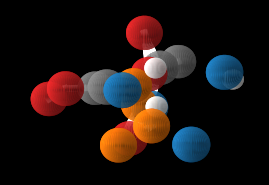

#### make a movie
first move all the images to the movie directory

In [63]:
import imageio
import os

In [64]:
path = args.model_path+ '/eval/movie/'
files = os.listdir(path)
files.reverse()
save_path = [path+x for x in files]

In [65]:
imgs = [imageio.imread(fn) for fn in save_path]
gif_path = path + 'output.gif'
print(f'Creating gif with {len(imgs)} images')
# Add the last frame 10 times so that the final result remains temporally.
imgs.extend([imgs[-1]] * 20)
imageio.mimsave(gif_path, imgs, subrectangles=True)


Creating gif with 101 images


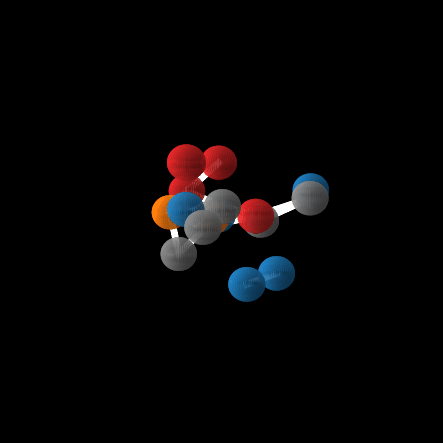